In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Choose which fields to use. 
def get_col_names(file_path):
  time_space = ['UTC_Start', 'G_LAT', 'G_LONG', 'G_ALT']
  names = pd.read_csv(file_path, skiprows=100, nrows=100).to_numpy()[:,0]
  col_names = time_space
  for item in names:
    if 'CAFS' in item and 'dnwFrac' not in item:  
      col_names.append(item) 
  return col_names

# Get the relevant data.    
def get_data(file_path, col_names):
  pre_rows = int((pd.read_csv(file_path, nrows=1, header=None))[0])
  relevant_data = pd.read_csv(file_path, skiprows=pre_rows-1, index_col=0, parse_dates=[0], usecols=col_names, na_values='-99999.0')
  return relevant_data

# Get the date and times.
def get_date_time(file_path, data):
  date = file_path[-16:-8]
  date = f'{date[0:4]}-{date[4:6]}-{date[6:8]}'
  data['UTC_Start_dt'] = pd.to_datetime(data.index, unit='s', origin=date)
  data.index = data['UTC_Start_dt']
  return date, data

In [ ]:
# Tests on 1 file.
file_path = '/content/drive/MyDrive/Documents/AI4ER/PhD/Photolysis_data/ATom_MER10_Dataset.20210613/MER10_DC8_20160729_R35.ict'
'''
col_names = get_col_names(file_path)
print(len(col_names))
print(col_names)

data = get_data(file_path, col_names)
print(data.shape)
print(data[0:2])

data = get_date_time(file_path, data)
print(data[0:2])
'''

'\ncol_names = get_col_names(file_path)\nprint(len(col_names))\nprint(col_names)\n\ndata = get_data(file_path, col_names)\nprint(data.shape)\nprint(data[0:2])\n\ndata = get_date_time(file_path, data)\nprint(data[0:2])\n'

In [16]:
# Compile all the photolysis data.
folder_path = '/content/drive/MyDrive/Documents/AI4ER/PhD/Photolysis_data/ATom_MER10_Dataset.20210613'
all_files = glob.glob(folder_path + '/*.ict')
all_data = []
for each_file in all_files:
   col_names = get_col_names(each_file) 
   data = get_data(each_file, col_names)
   date, data = get_date_time(each_file, data)
   all_data.append(data)
all_data = pd.concat(all_data, axis=0)
all_data = all_data.drop(['UTC_Start_dt'], axis=1)

del col_names
del data


In [7]:
# Make a .csv for easy viewing.
out_path = folder_path + '/photolysis_data.csv'
all_data.to_csv(out_path)

(149133, 49)


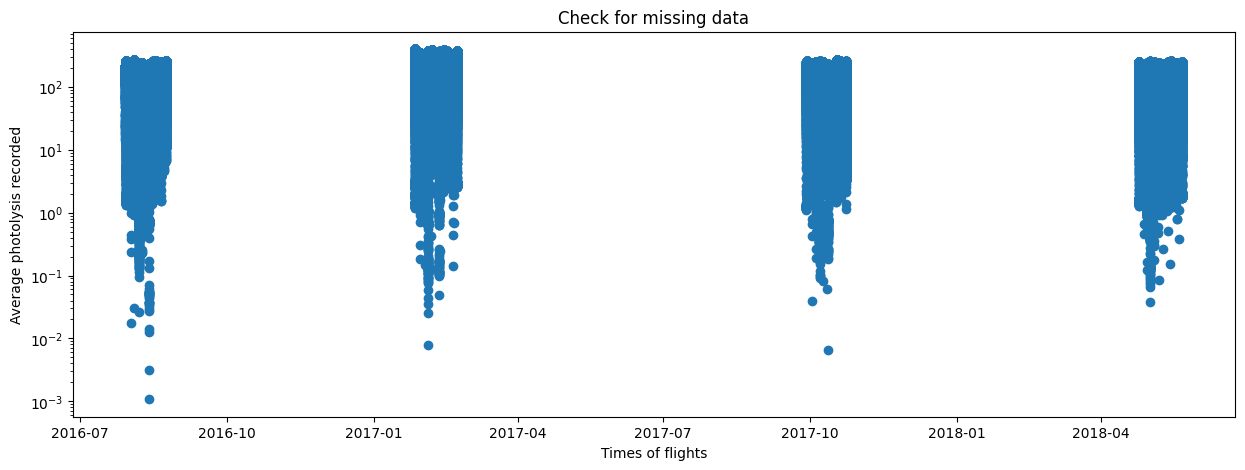

(138454, 49)
138454
There were 10679 entries with no photolysis.


In [31]:
def scatter(title, x, y, xlabel, ylabel, scale):
  plt.figure(figsize=(15, 5))
  plt.yscale(scale)
  plt.scatter(x, y)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

# Show where there are no photolysis data.
title = 'Check for missing data'
xlabel = 'Times of flights'
ylabel = 'Average photolysis recorded'

x = all_data.index
y = all_data.mean(axis=1)
#scatter(title, x, y, xlabel, ylabel)
print(all_data.shape)

# Remove entries with no photolysis data but keep entries with some recorded and some missing.
no_empty_data = all_data.dropna(axis='rows', thresh=4)
x = no_empty_data.index
y = no_empty_data.mean(axis=1)
scatter(title, x, y, xlabel, ylabel, 'log')
print(no_empty_data.shape)
print(len(no_empty_data.index))

num_empties = len(all_data.index) - len(no_empty_data.index)
print("There were {} entries with no photolysis.".format(num_empties))

In [ ]:
# Remove empty entries from csv.
out_path = folder_path + '/photolysis_data.csv'
no_empty_data.to_csv(out_path)

150693 negative values 

The smallest numbers are:
 jPAN_CH3COO_NO3_CAFS                      -2.720410e-10
jMAC_NoProductsSpecified_CAFS             -2.139323e-09
jMVK_NoProductsSpecified_CAFS             -9.179383e-09
jAcetone_CH3CO_CH3_CAFS                   -5.892033e-09
jMEK_CH3CO_CH2CH3_CAFS                    -2.227165e-08
jHydroxyacetone_CH3CO_CH3O_CAFS           -2.471936e-09
jHydroxyacetone_CH3COO_CH3_CAFS           -2.471936e-09
jCHOCHO_HCO_HCO_CAFS                      -2.614505e-08
jCHOCHO_H2_2CO_CAFS                       -2.005149e-08
jCHOCHO_CH2O_CO_CAFS                      -3.032936e-08
jCH3COCHO_CH3CO_HCO_CAFS                  -7.560872e-08
j23Butanedione_NoProductsSpecified_CAFS   -5.347400e-08
jCl2_Cl_Cl_CAFS                           -8.736500e-07
jClO_Cl_O3P_CAFS                          -3.481537e-07
jClNO2_Cl_NO2_CAFS                        -2.477252e-07
jClONO_Cl_NO2_CAFS                        -2.814867e-06
jClONO2_Cl_NO3_CAFS                       -2.040188e

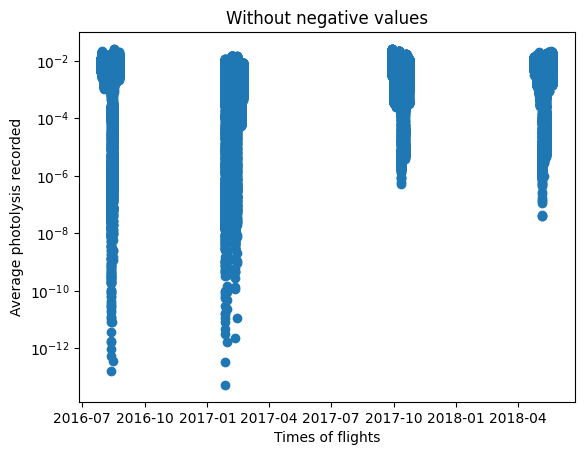

In [12]:
# Check for outlying values.
# Separate spatial info from data for easier processing.
space_data = data.iloc[0, 0:3]
j_data = data.iloc[:, 4:-1]
# Check for negative values.
print((j_data < 0).sum().sum(), "negative values \n")
#print(j_data[(j_data < 0).any(axis=1)])
print("The smallest numbers are:\n", j_data.min(axis=0))
# Since the negative numbers are so close to zero, I assume they are actually zero.
j_data[j_data < 0] = 0.0
print((j_data < 0).sum().sum(), "negative values \n")
# Check for unreasonably large numbers.
print("The largest numbers are:\n", j_data.max(axis=0))

title = "Without negative values"
x = j_data.index
y = j_data.mean(axis=1)
scatter(title, x, y, xlabel, ylabel, 'log')

In [8]:
# Remove negative values from csv.
out_path = folder_path + '/photolysis_data.csv'
j_data.to_csv(out_path)

8494 negative values in data

0 negative values in j_data

4311 negative values in j_data

0 negative values in j_data

4183 negative values in data



<ipython-input-47-0ff4c8d6498b>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  j_data[j_data < 0] = 0.0
<ipython-input-47-0ff4c8d6498b>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  j_data[j_data < 0] = 0.0


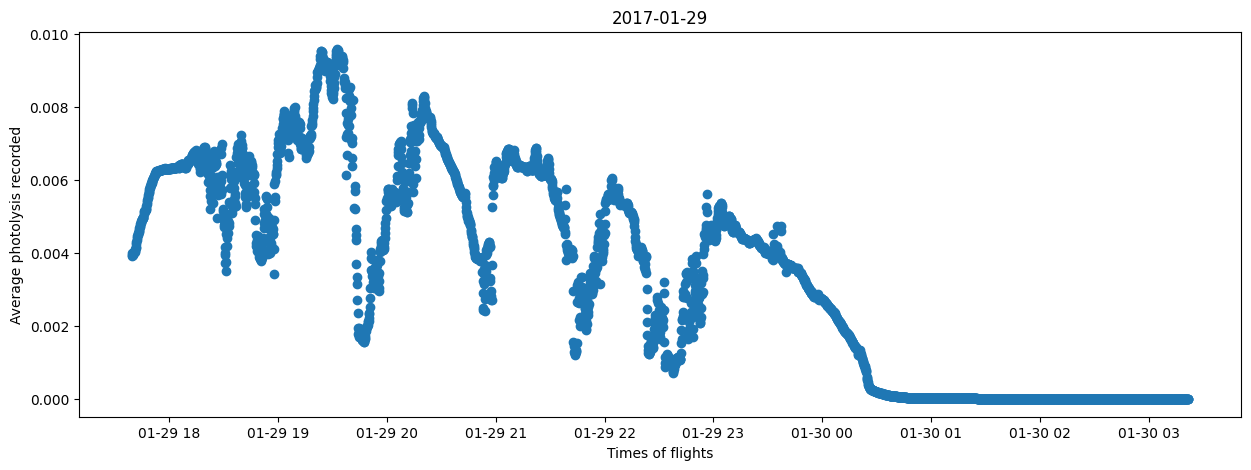

In [47]:
# Look at rates during the progression of 1 flight of data.
file_path = '/content/drive/MyDrive/Documents/AI4ER/PhD/Photolysis_data/ATom_MER10_Dataset.20210613/MER10_DC8_20170129_R25.ict'
col_names = get_col_names(file_path) 
data = get_data(file_path, col_names)
date, data = get_date_time(file_path, data)
data = data.drop(['UTC_Start_dt'], axis=1)
data = data.dropna(axis='rows', thresh=4)
space_data = data.iloc[0, 0:3]
j_data = data.iloc[:, 4:-1]
j_data[j_data < 0] = 0.0

title = date
x = j_data.index
y = j_data.mean(axis=1)
scatter(title, x, y, xlabel, ylabel, 'linear')

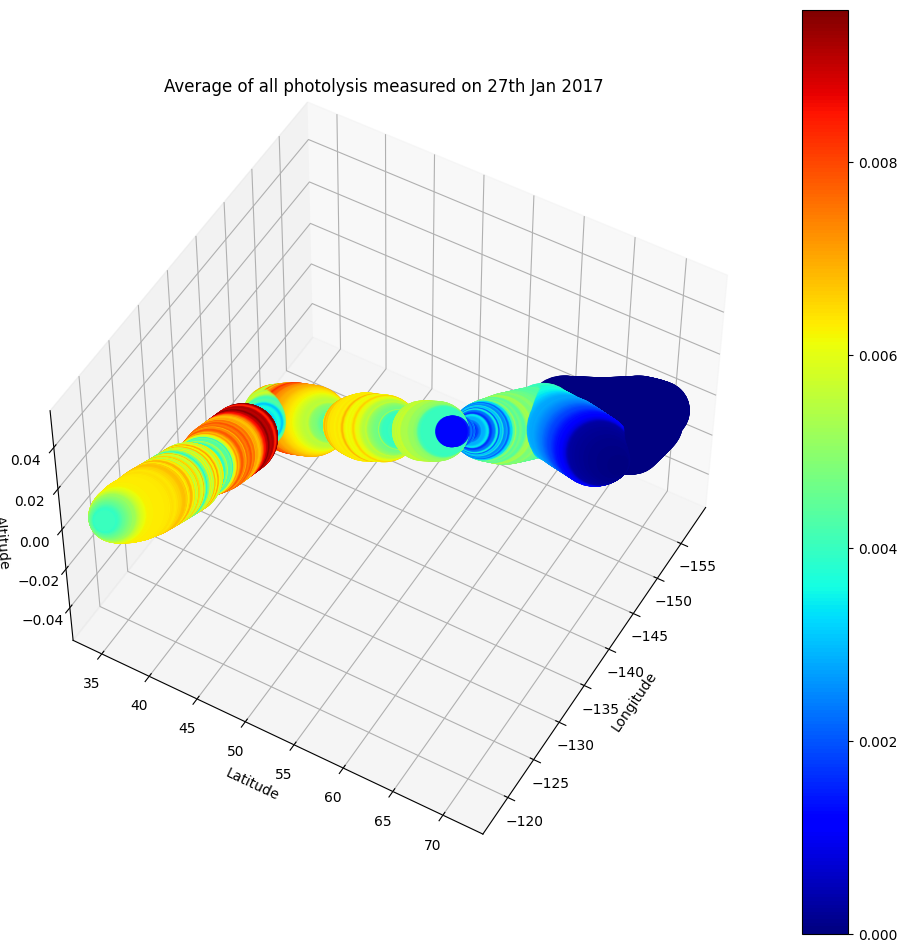

In [137]:
# Plot an example of photolysis rates in space during 1 flight.
x = data['G_LONG']
y = data['G_LAT']
z = data['G_ALT']
j_avg = j_data.mean(axis=1)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection="3d")
pic = plt.scatter(x, y, z, c=j_avg, cmap='jet', marker='.')
plt.colorbar(pic)
plt.title("Average of all photolysis measured on 27th Jan 2017")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
ax.set_zlabel("Altitude")
ax.view_init(50, 30)
#ax.view_init(90, -90)
#ax.view_init(0, 45)
plt.show()

In [ ]:
del all_data
del no_empty_data
del j_data